<a href="https://colab.research.google.com/github/haythemtellili/Great-notebook/blob/master/TWEET_Covid_classification(1stplace).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://miro.medium.com/max/1200/1*eCE-OsWxx7NYivrxt69QOw.png)

In [ ]:
! pip install pytorch-transformers
! pip install transformers

     |████████████████████████████████| 184kB 3.4MB/s 
     |████████████████████████████████| 890kB 15.4MB/s 
     |████████████████████████████████| 1.1MB 21.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e37e0b6326cbd1df009998e8b9e36cc20d2fa1941551bd678b52f647e3785e66
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 3.0MB 17.3MB/s 


In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
import os

from fastai.text import *
from fastai.metrics import *

from fastai.callbacks import *
from transformers import AdamW
from functools import partial
from pytorch_transformers import RobertaModel

import torch
import torch.nn as nn

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

In [ ]:
seed = 1024

def seed_all(seed_value):
    random.seed(seed_value) 
    np.random.seed(seed_value) 
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False
        
seed_all(seed)

In [ ]:
train=pd.read_csv('/content/drive/My Drive/tweet/updated_train.csv')
test=pd.read_csv('/content/drive/My Drive/tweet/updated_test.csv')
sub=pd.read_csv('/content/My Drive/updated_ss(1).csv')

In [ ]:
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [ ]:
train.shape

(5287, 3)

In [ ]:

feat_cols = "text"
label_cols = "target"

train["text"] = train["text"].str.lower()
train = train.drop_duplicates(subset=['text', 'target'])

test["text"] = test["text"].str.lower()

test[feat_cols] = test[feat_cols].astype(str)
train[feat_cols] = train[feat_cols].astype(str)

## DATA SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.text, train.target, 
                                                    test_size=0.1, stratify=train.target, random_state=seed)

train['is_valid'] = True
train.loc[X_train.index, 'is_valid'] = False

In [ ]:
# Creating a config object to store task specific information
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)
        
config = Config(
    testing=False,
    seed = 2019,
    roberta_model_name='roberta-base', # can also be exchnaged with roberta-large 
    max_lr=2e-5,
    epochs=2,
    use_fp16=False,
    bs=4, 
    max_seq_len=64, 
    num_labels = 2,
    hidden_dropout_prob=.05,
    hidden_size=768, # 1024 for roberta-large
    start_tok = "<s>",
    end_tok = "</s>",
)

class FastAiRobertaTokenizer(BaseTokenizer):
    """Wrapper around RobertaTokenizer to be compatible with fastai"""
    def __init__(self, tokenizer: RobertaTokenizer, max_seq_len: int=128, **kwargs): 
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len 
    def __call__(self, *args, **kwargs): 
        return self 
    def tokenizer(self, t:str) -> List[str]: 
        """Adds Roberta bos and eos tokens and limits the maximum sequence length""" 
        return [config.start_tok] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + [config.end_tok]
    
# create fastai tokenizer for roberta
roberta_tok = RobertaTokenizer.from_pretrained("roberta-base")

fastai_tokenizer = Tokenizer(tok_func=FastAiRobertaTokenizer(roberta_tok, max_seq_len=config.max_seq_len), 
                             pre_rules=[], post_rules=[])

# create fastai vocabulary for roberta
path = Path()
roberta_tok.save_vocabulary(path)

with open('vocab.json', 'rb') as f:
    roberta_vocab_dict = json.load(f)
    
fastai_roberta_vocab = Vocab(list(roberta_vocab_dict.keys()))

# Setting up pre-processors
class RobertaTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
         super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class RobertaNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=fastai_roberta_vocab, **kwargs)


def get_roberta_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for Roberta
    We remove sos and eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original Roberta model.
    """
    return [RobertaTokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(vocab=vocab)]

# Creating a Roberta specific DataBunch class
class RobertaDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training Roberta"
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=64, val_bs:int=None, pad_idx=1,
               pad_first=True, device:torch.device=None, no_check:bool=False, backwards:bool=False, 
               dl_tfms:Optional[Collection[Callable]]=None, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(pad_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, dl_tfms=dl_tfms, collate_fn=collate_fn, no_check=no_check)

class RobertaTextList(TextList):
    _bunch = RobertaDataBunch
    _label_cls = TextList
    
    
feat_cols = "text"
label_cols = "target"

processor = get_roberta_processor(tokenizer=fastai_tokenizer, vocab=fastai_roberta_vocab)

data = RobertaTextList.from_df(train, ".", cols=feat_cols, processor=processor) \
        .split_from_df('is_valid') \
        .label_from_df(cols=label_cols, label_cls=CategoryList) \
        .add_test(RobertaTextList.from_df(test, ".", cols=feat_cols, processor=processor)) \
        .databunch(bs=4, pad_first=False, pad_idx=0)

In [ ]:
# defining our model architecture 
class CustomRobertaModel(nn.Module):
    def __init__(self,num_labels=2):
        super(CustomRobertaModel,self).__init__()
        self.num_labels = num_labels
        self.roberta = RobertaModel.from_pretrained(config.roberta_model_name)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _ , pooled_output = self.roberta(input_ids, token_type_ids, attention_mask) 
        logits = self.classifier(pooled_output)        
        return logits
    
roberta_model = CustomRobertaModel()
CustomAdamW = partial(AdamW, correct_bias=False)

seed_all(seed)

learn = Learner(data, roberta_model, metrics=[accuracy, error_rate, FBeta(beta=1, average='macro')]) # 
learn.callbacks.append(ShowGraph(learn))

## MODEL TRAINING

In [ ]:
learn.model.roberta.train()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=0)
    (position_embeddings): Embedding(514, 768)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time
0,0.255786,0.204430,0.913043,0.086957,0.913036,03:18
1,0.189331,0.197714,0.933837,0.066163,0.933803,03:18


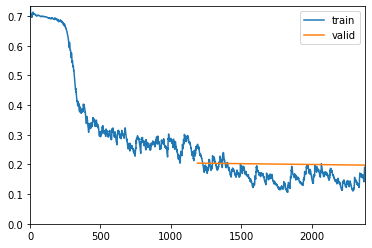

In [ ]:
learn.fit_one_cycle(config.epochs, max_lr=config.max_lr)


## INFERENCE

In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    learn.model.roberta.eval()
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    ordered_preds = preds[reverse_sampler, :]
    pred_values = np.argmax(ordered_preds, axis=1)
    return ordered_preds, pred_values


test_preds,preds = get_preds_as_nparray(DatasetType.Test)
df=pd.DataFrame(data=test_preds,columns=['a','b'])
sub['target']=df['b']
sub.to_csv('tweet_win.csv',index=False)

In [ ]:
sub.head(10)

,ID,target
0,test_2,0.982313
1,test_3,0.001234
2,test_4,0.001780
3,test_8,0.912273
4,test_9,0.001953
5,test_10,0.001264
6,test_11,0.127850
7,test_14,0.155842
8,test_16,0.988733
9,test_19,0.682924


![alt text](https://analyticsindiamag.com/wp-content/uploads/2019/12/Transformer-04-scaled.jpg)

In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 3.0MB 13.7MB/s 
     |████████████████████████████████| 890kB 25.2MB/s 
     |████████████████████████████████| 1.1MB 39.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=a72a279d1609853e953741ec7f6496e84a7ea98e936d251c7e0db45e83cd65e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 71kB 5.7MB/s 
     |████████████████████████████████| 317kB 8.3MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=ccdd2aecafff14b0dcc4867e332d51091847757af92948293cfbed7c8244ab0c
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval
  Found existing installatio

In [ ]:
import gc
import sklearn
from sklearn.metrics import log_loss
import re
import random
import torch
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [ ]:
train=pd.read_csv('/content/drive/My Drive/tweet/updated_train.csv')
test=pd.read_csv('/content/drive/My Drive/tweet/updated_test.csv')

train1=train.drop(['ID'],axis=1)
test1=test.drop(['ID'],axis=1)
test1['label']=0

In [ ]:


%%time
err=[]
y_pred_tot=[]

fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
i=1
for train_index, test_index in fold.split(train1,train1['target']):
    train1_trn, train1_val = train1.iloc[train_index], train1.iloc[test_index]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args={'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True})
    model.train_model(train1_trn)
    raw_outputs_val = model.eval_model(train1_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train1_val['target'], raw_outputs_val)}")
    err.append(log_loss(train1_val['target'], raw_outputs_val))
    raw_outputs_test = model.eval_model(test1)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    y_pred_tot.append(raw_outputs_test)
print("Mean LogLoss: ",np.mean(err))
sub=pd.DataFrame()
sub['ID']=test['ID']
sub['target']=np.mean(y_pred_test, 0)
sub.to_csv('simple_transformers1.csv',index=False)

